In [1]:
from utils import *
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')



In [2]:
df = pd.read_csv('data/features_30_sec.csv') 
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i 
    index_label[i] = x
    
# update labels in df to index
df.label = [label_index[l] for l in df.label]

# length is not an informative feature so we just drop it
y = df['label']
X = df.drop(columns = ['label','filename','length'])



In [3]:
# Scaling and Data Spiltting  
X = standardize(X)
X_dev, y_dev, X_test, y_test = split(X, y)



X_dev shape: (800, 57)
X_test shape: (200, 57)


# HistGradientBoosting

### Original Model (untuned)
Building a model with no parameter tuning and using the raw csv file

In [4]:
model_hgb = HistGradientBoostingClassifier()
model_hgb.fit(X_dev, y_dev)
predsDevhgb = model_hgb.predict(X_dev)
predsTesthgb = model_hgb.predict(X_test)

In [5]:
testhgb_score =  accuracy_score(y_test, predsTesthgb)
devhgb_score = accuracy_score(y_dev, predsDevhgb)

In [6]:
print("Classification Score for HistGradientBoosting on Dev dataset:\n")
print("Dev Score : ", devhgb_score)
print(classification_report(y_dev, predsDevhgb))
print("--------------------------------------------------------")
print("Classification Score for HistGradientBoosting on Test dataset:\n")
print("Test Score :", testhgb_score)
print(classification_report(y_test, predsTesthgb))

Classification Score for HistGradientBoosting on Dev dataset:

Dev Score :  0.99875
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        84
           2       1.00      1.00      1.00        78
           3       1.00      1.00      1.00        78
           4       1.00      1.00      1.00        81
           5       1.00      1.00      1.00        71
           6       0.99      1.00      0.99        81
           7       1.00      1.00      1.00        84
           8       1.00      1.00      1.00        78
           9       1.00      0.99      0.99        77

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800

--------------------------------------------------------
Classification Score for HistGradientBoosting on Test dataset:

Test Score : 0.765
              pre

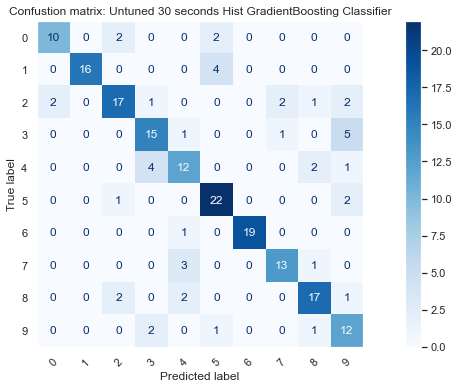

Accuracy : 0.77
Macro F-1 Score : 0.77


In [7]:
# Evaluate Model on Test set
class_labels = list(model_hgb.classes_)
macro_f1, accuracy = evaluate_model(predsTesthgb, y_test, class_labels,
                                    'Confustion matrix: Untuned 30 seconds Hist GradientBoosting Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the raw csv file

In [8]:
hgb_param_grid = {"max_iter": [100, 200, 300],
                  "learning_rate": np.random.uniform(0.01, 0.3, 3),
                  "max_depth": [4, 6, 8]}
hgb_param_grid

{'max_iter': [100, 200, 300],
 'learning_rate': array([0.09512011, 0.02165036, 0.13450908]),
 'max_depth': [4, 6, 8]}

In [9]:
grid_search_hgb = GridSearchCV(model_hgb, 
                           param_grid = hgb_param_grid, 
                           cv = 5,
                           n_jobs=-1)



grid_search_hgb.fit(X_dev, y_dev)
print("Best parameter set is: {}".format(grid_search_hgb.best_params_))
best_hgb = grid_search_hgb.best_estimator_
best_hgb.fit(X_dev, y_dev)

predsDevhgb_tuned = best_hgb.predict(X_dev)
predsTesthgb_tuned = best_hgb.predict(X_test)

print("Score on Dev data for hgb using GridSearchCV:", accuracy_score(y_dev, predsDevhgb_tuned))
print("Score on Test data for hgb using GridSearchCV:",accuracy_score(y_test, predsTesthgb_tuned))

Best parameter set is: {'learning_rate': 0.09512011480769186, 'max_depth': 4, 'max_iter': 200}
Score on Dev data for hgb using GridSearchCV: 0.99875
Score on Test data for hgb using GridSearchCV: 0.745


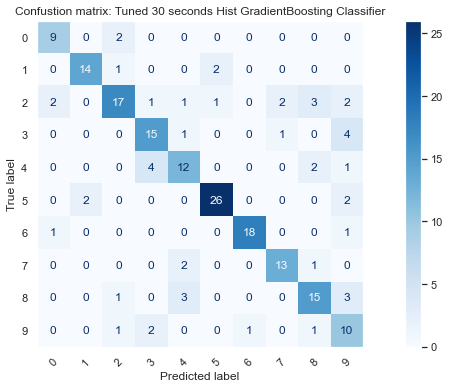

Accuracy : 0.74
Macro F-1 Score : 0.75


In [10]:
# Evaluate Model on Test set
class_labels = list(best_hgb.classes_)
macro_f1, accuracy = evaluate_model(predsTesthgb_tuned, y_test, class_labels,
                                    'Confustion matrix: Tuned 30 seconds Hist GradientBoosting Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

# GradientBoosting

In [11]:
model_gb = GradientBoostingClassifier()
model_gb.fit(X_dev, y_dev)
predsDevgb = model_gb.predict(X_dev)
predsTestgb = model_gb.predict(X_test)

In [12]:
testgb_score =  accuracy_score(y_test, predsTestgb)
devgb_score = accuracy_score(y_dev, predsDevgb)

In [13]:
print("Classification Score for GradientBoostingClassifier on Dev dataset:\n")
print("Dev Score : ", devgb_score)
print(classification_report(y_dev, predsDevgb))
print("--------------------------------------------------------")
print("Classification Score for GradientBoostingClassifier on Test dataset:\n")
print("Test Score :", testgb_score)
print(classification_report(y_test, predsTestgb))

Classification Score for GradientBoostingClassifier on Dev dataset:

Dev Score :  0.99875
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        84
           2       1.00      1.00      1.00        78
           3       1.00      1.00      1.00        78
           4       1.00      1.00      1.00        81
           5       1.00      1.00      1.00        71
           6       0.99      1.00      0.99        81
           7       1.00      1.00      1.00        84
           8       1.00      1.00      1.00        78
           9       1.00      0.99      0.99        77

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800

--------------------------------------------------------
Classification Score for GradientBoostingClassifier on Test dataset:

Test Score : 0.745
     

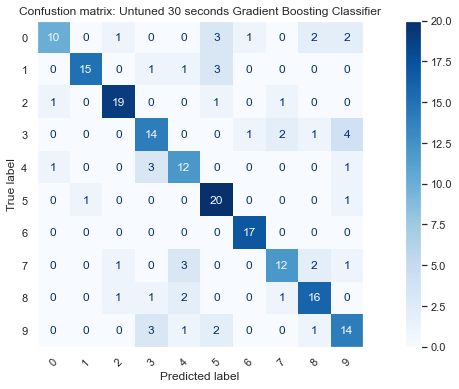

Accuracy : 0.74
Macro F-1 Score : 0.74


In [14]:
# Evaluate Model on Test set
class_labels = list(model_gb.classes_)
macro_f1, accuracy = evaluate_model(predsTestgb, y_test, class_labels,
                                    'Confustion matrix: Untuned 30 seconds Gradient Boosting Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the raw csv file

In [15]:
gb_param_grid = {"n_estimators": [100],
                 "learning_rate": [0.1],
                 "max_depth": random.sample(range(3, 8), 2)}
gb_param_grid

{'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [6, 3]}

In [16]:
grid_search_gb = GridSearchCV(estimator =  model_gb, 
                           param_grid = gb_param_grid, 
                           cv = 5,
                           n_jobs=-1)



grid_search_gb.fit(X_dev, y_dev)
print("Best parameter set is: {}".format(grid_search_gb.best_params_))
best_gb = grid_search_gb.best_estimator_
best_gb.fit(X_dev, y_dev)

predsDevgb_tuned = best_gb.predict(X_dev)
predsTestgb_tuned = best_gb.predict(X_test)

print("Score on Dev data for gb using GridSearchCV:", accuracy_score(y_dev, predsDevgb_tuned))
print("Score on Test data for gb using GridSearchCV:",accuracy_score(y_test, predsTestgb_tuned))

Best parameter set is: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Score on Dev data for gb using GridSearchCV: 0.99875
Score on Test data for gb using GridSearchCV: 0.735


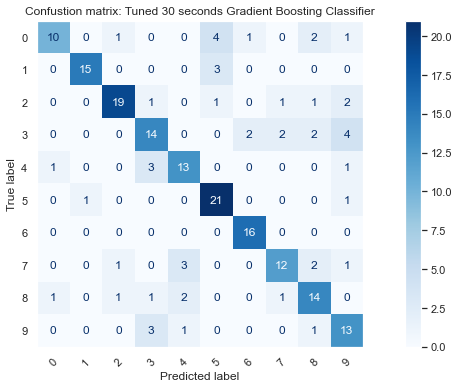

Accuracy : 0.73
Macro F-1 Score : 0.74


In [17]:
# Evaluate Model on Test set
class_labels = list(best_gb.classes_)
macro_f1, accuracy = evaluate_model(predsTestgb_tuned, y_test, class_labels,
                                    'Confustion matrix: Tuned 30 seconds Gradient Boosting Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

# XGB

In [18]:
model_xgb = XGBClassifier()
model_xgb.fit(X_dev, y_dev)
predsDevxgb = model_xgb.predict(X_dev)
predsTestxgb = model_xgb.predict(X_test)

In [19]:
testxgb_score =  accuracy_score(y_test, predsTestxgb)
devxgb_score = accuracy_score(y_dev, predsDevxgb)

In [20]:
print("Classification Score for XGBClassifier on Dev dataset:\n")
print("Dev Score : ", devxgb_score)
print(classification_report(y_dev, predsDevxgb))
print("--------------------------------------------------------")
print("Classification Score for XGBClassifier on Test dataset:\n")
print("Test Score :", testxgb_score)
print(classification_report(y_test, predsTestxgb))

Classification Score for XGBClassifier on Dev dataset:

Dev Score :  0.99875
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        84
           2       1.00      1.00      1.00        78
           3       1.00      1.00      1.00        78
           4       1.00      1.00      1.00        81
           5       1.00      1.00      1.00        71
           6       0.99      1.00      0.99        81
           7       1.00      1.00      1.00        84
           8       1.00      1.00      1.00        78
           9       1.00      0.99      0.99        77

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800

--------------------------------------------------------
Classification Score for XGBClassifier on Test dataset:

Test Score : 0.765
              precision    reca

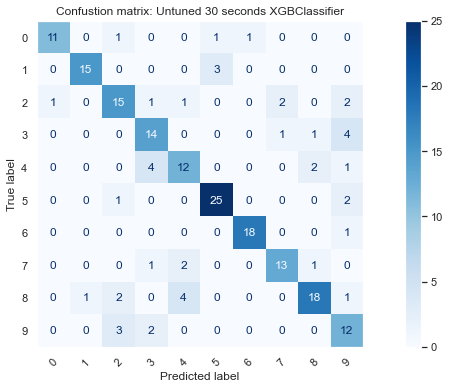

Accuracy : 0.77
Macro F-1 Score : 0.77


In [21]:
# Evaluate Model on Test set
class_labels = list(model_xgb.classes_)
macro_f1, accuracy = evaluate_model(predsTestxgb, y_test, class_labels,
                                    'Confustion matrix: Untuned 30 seconds XGBClassifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the raw csv file

In [22]:
xgb_param_grid={"n_estimators": [100],
            "learning_rate": [0.1],
            "max_depth": random.sample(range(3, 8), 2),
            'eval_metric':['logloss'],
            "use_label_encoder": [False]}
xgb_param_grid

{'n_estimators': [100],
 'learning_rate': [0.1],
 'max_depth': [4, 5],
 'eval_metric': ['logloss'],
 'use_label_encoder': [False]}

In [23]:
grid_search_xgb = GridSearchCV(estimator =  model_xgb, 
                           param_grid = xgb_param_grid, 
                           cv = 5,
                           n_jobs=-1)



grid_search_xgb.fit(X_dev, y_dev)
print("Best parameter set is: {}".format(grid_search_xgb.best_params_))
best_xgb = grid_search_xgb.best_estimator_
best_xgb.fit(X_dev, y_dev)

predsDevxgb_tuned = best_xgb.predict(X_dev)
predsTestxgb_tuned = best_xgb.predict(X_test)

print("Score on Dev data for xgb using GridSearchCV:", accuracy_score(y_dev, predsDevxgb_tuned))
print("Score on Test data for xgb using GridSearchCV:",accuracy_score(y_test, predsTestxgb_tuned))

Best parameter set is: {'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'use_label_encoder': False}
Score on Dev data for xgb using GridSearchCV: 0.99875
Score on Test data for xgb using GridSearchCV: 0.74


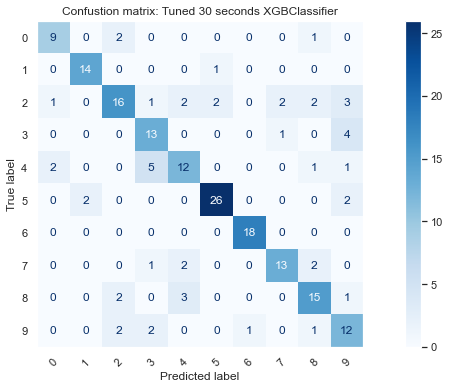

Accuracy : 0.74
Macro F-1 Score : 0.74


In [24]:
# Evaluate Model on Test set
class_labels = list(best_xgb.classes_)
macro_f1, accuracy = evaluate_model(predsTestxgb_tuned, y_test, class_labels,
                                    'Confustion matrix: Tuned 30 seconds XGBClassifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

# SVM

In [25]:
model_svm = SVC()
model_svm.fit(X_dev, y_dev)
predsDevsvm = model_svm.predict(X_dev)
predsTestsvm = model_svm.predict(X_test)

In [26]:
testsvm_score =  accuracy_score(y_test, predsTestsvm)
devsvm_score = accuracy_score(y_dev, predsDevsvm)

In [27]:
print("Classification Score for SVM on Dev dataset:\n")
print("Dev Score : ", devsvm_score)
print(classification_report(y_dev, predsDevsvm))
print("--------------------------------------------------------")
print("Classification Score for SVM on Test dataset:\n")
print("Test Score :", testsvm_score)
print(classification_report(y_test, predsTestsvm))

Classification Score for SVM on Dev dataset:

Dev Score :  0.76375
              precision    recall  f1-score   support

           0       0.75      0.78      0.77        88
           1       0.95      0.98      0.96        84
           2       0.74      0.71      0.72        78
           3       0.58      0.73      0.65        78
           4       0.82      0.63      0.71        81
           5       0.89      0.82      0.85        71
           6       0.78      0.94      0.85        81
           7       0.85      0.83      0.84        84
           8       0.72      0.73      0.73        78
           9       0.55      0.47      0.51        77

    accuracy                           0.76       800
   macro avg       0.77      0.76      0.76       800
weighted avg       0.77      0.76      0.76       800

--------------------------------------------------------
Classification Score for SVM on Test dataset:

Test Score : 0.72
              precision    recall  f1-score   suppor

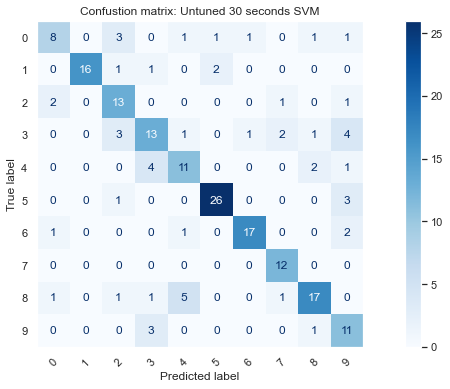

Accuracy : 0.72
Macro F-1 Score : 0.72


In [28]:
# Evaluate Model on Test set
class_labels = list(model_svm.classes_)
macro_f1, accuracy = evaluate_model(predsTestsvm, y_test, class_labels,
                                    'Confustion matrix: Untuned 30 seconds SVM')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the raw csv file

In [29]:
svm_param_grid={"kernel": ['linear', 'rbf', 'sigmoid'],
            "C": [0.001, 0.01, 0.1, 1, 10],
            "gamma": [0.001, 0.01, 0.1, 1]}
svm_param_grid

{'kernel': ['linear', 'rbf', 'sigmoid'],
 'C': [0.001, 0.01, 0.1, 1, 10],
 'gamma': [0.001, 0.01, 0.1, 1]}

In [30]:
grid_search_svm = GridSearchCV(estimator =  model_svm, 
                           param_grid = svm_param_grid, 
                           cv = 5,
                           n_jobs=-1)


grid_search_svm.fit(X_dev, y_dev)
print("Best parameter set is: {}".format(grid_search_svm.best_params_))
best_svm = grid_search_svm.best_estimator_
best_svm.fit(X_dev, y_dev)

predsDevsvm_tuned = best_svm.predict(X_dev)
predsTestsvm_tuned = best_svm.predict(X_test)

print("Score on Dev data for SVM using GridSearchCV:", accuracy_score(y_dev, predsDevsvm_tuned))
print("Score on Test data for SVM using GridSearchCV:",accuracy_score(y_test, predsTestsvm_tuned))

Best parameter set is: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Score on Dev data for SVM using GridSearchCV: 0.99875
Score on Test data for SVM using GridSearchCV: 0.77


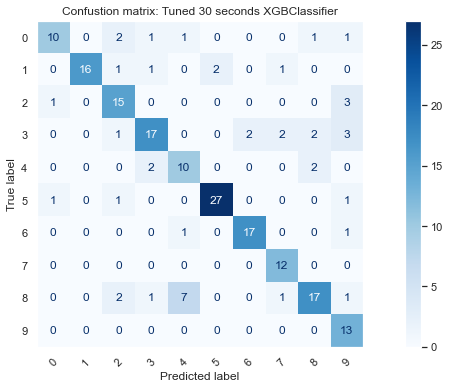

Accuracy : 0.77
Macro F-1 Score : 0.77


In [31]:
# Evaluate Model on Test set
class_labels = list(best_svm.classes_)
macro_f1, accuracy = evaluate_model(predsTestsvm_tuned, y_test, class_labels,
                                    'Confustion matrix: Tuned 30 seconds XGBClassifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

# Dimensionality reduction of data using PCA

In [32]:
# Principal Component Analysis 
### cite : https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

# create the PCA instance
pca = PCA(n_components=30)
# fit on data
pca_data = pca.fit_transform(X_dev)
pca_data_test = pca.transform(X_test)
# pca_data_dev = pca.transform(X_dev)
PCA_df= pd.DataFrame(data=pca_data)
y_dev.index = PCA_df.index
pca_final=pd.concat([PCA_df,y_dev], axis = 1)
# access values
print("Explained Variance of each component:",pca.explained_variance_)
print("Sum of Explained Variance:", sum(pca.explained_variance_ratio_))

Explained Variance of each component: [0.27766419 0.24831461 0.10817539 0.0735775  0.05921353 0.04313114
 0.03041835 0.02485929 0.02357102 0.0185913  0.01458576 0.01445453
 0.01236632 0.01085371 0.01042908 0.00964281 0.00916207 0.00839637
 0.00793385 0.00728807 0.00723336 0.00675814 0.00606176 0.00560799
 0.0055164  0.00512505 0.00504721 0.00464988 0.00453897 0.00424095]
Sum of Explained Variance: 0.9554564819451608


In [33]:
pca_final.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
0,-0.777410,0.193198,-0.058681,-0.180358,-0.005488,-0.099418,-0.209192,-0.328523,0.078996,-0.157323,...,0.038868,-0.014776,0.077619,0.042378,-0.022349,0.027487,0.072776,0.064374,-0.002495,0
1,-0.599829,0.260505,0.001988,-0.047122,0.131503,-0.098224,-0.077306,0.046255,-0.040616,0.094603,...,-0.046373,-0.068694,-0.016307,0.047816,0.034589,0.010604,0.052721,0.011093,-0.018114,9
2,-0.246233,-0.118150,0.065454,-0.036683,0.486624,-0.150015,-0.066610,-0.197734,0.041883,0.013262,...,0.035792,0.010247,-0.059556,-0.157718,-0.009606,0.117418,0.033817,0.003053,-0.032089,8
3,-0.748761,0.347893,-0.050810,-0.060772,0.094122,0.043072,-0.091611,0.131255,-0.044354,0.123954,...,0.002813,-0.002246,-0.016255,0.033266,-0.038578,0.011985,0.000457,0.015948,-0.024016,9
4,0.390897,0.250941,-0.198188,0.293123,0.621651,0.005957,-0.025039,-0.233490,0.295023,0.131552,...,-0.082243,0.057713,-0.016134,-0.016780,0.004757,-0.044126,-0.030980,-0.015806,0.015246,8


## HistGradientBoosting

### PCA - Original Model
Building a model with no parameter tuning and using the PCA data

In [34]:
model_pca_hbg = HistGradientBoostingClassifier()
model_pca_hbg.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainhbg = model_pca_hbg.predict(pca_data)
pcaTesthbg = model_pca_hbg.predict(pca_data_test)

In [35]:
pcatesthbg_score =  accuracy_score(y_test, pcaTesthbg)
pcahbg_score = accuracy_score(y_dev, pcaTrainhbg)

In [36]:
print("Classification Score for HistGradientBoosting Classifier on Train dataset:\n")
print("Train Score : ", pcahbg_score)
print("--------------------------------------------------------")
print("Classification Score for HistGradientBoosting Classifier on Test dataset:\n")
print("Test Score :", pcatesthbg_score)

Classification Score for HistGradientBoosting Classifier on Train dataset:

Train Score :  0.99875
--------------------------------------------------------
Classification Score for HistGradientBoosting Classifier on Test dataset:

Test Score : 0.74


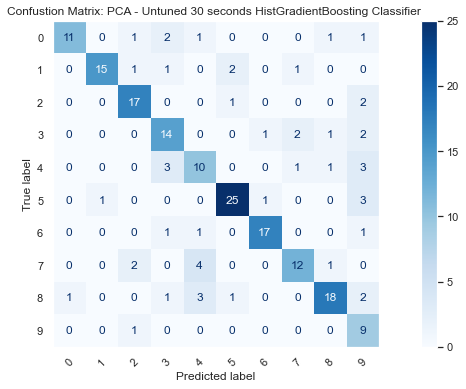

Accuracy : 0.74
Macro F-1 Score : 0.73


In [37]:
# Evaluate Model
class_labels = list(model_pca_hbg.classes_)
macro_f1, accuracy = evaluate_model(pcaTesthbg, y_test, class_labels,
                                    'Confustion Matrix: PCA - Untuned 30 seconds HistGradientBoosting Classifier ')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### PCA - Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the PCA data

In [38]:
pca_final.iloc[:,:30]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.777410,0.193198,-0.058681,-0.180358,-0.005488,-0.099418,-0.209192,-0.328523,0.078996,-0.157323,...,0.041165,0.038868,-0.014776,0.077619,0.042378,-0.022349,0.027487,0.072776,0.064374,-0.002495
1,-0.599829,0.260505,0.001988,-0.047122,0.131503,-0.098224,-0.077306,0.046255,-0.040616,0.094603,...,-0.041534,-0.046373,-0.068694,-0.016307,0.047816,0.034589,0.010604,0.052721,0.011093,-0.018114
2,-0.246233,-0.118150,0.065454,-0.036683,0.486624,-0.150015,-0.066610,-0.197734,0.041883,0.013262,...,0.088581,0.035792,0.010247,-0.059556,-0.157718,-0.009606,0.117418,0.033817,0.003053,-0.032089
3,-0.748761,0.347893,-0.050810,-0.060772,0.094122,0.043072,-0.091611,0.131255,-0.044354,0.123954,...,-0.015460,0.002813,-0.002246,-0.016255,0.033266,-0.038578,0.011985,0.000457,0.015948,-0.024016
4,0.390897,0.250941,-0.198188,0.293123,0.621651,0.005957,-0.025039,-0.233490,0.295023,0.131552,...,0.016740,-0.082243,0.057713,-0.016134,-0.016780,0.004757,-0.044126,-0.030980,-0.015806,0.015246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-0.565572,0.422083,0.328459,0.111136,-0.153392,-0.133144,0.121274,0.170829,0.181531,-0.003553,...,0.293489,-0.012800,0.058350,0.047841,0.083061,-0.066748,0.014930,-0.025305,-0.000576,0.010976
796,0.258810,-0.934083,0.031836,0.495334,0.077337,-0.114135,0.171023,-0.128289,0.103747,0.171771,...,0.028867,-0.007606,-0.040242,0.058971,0.156630,0.046094,-0.127337,-0.039484,0.098118,0.001165
797,1.243638,0.799851,0.648936,0.304699,-0.379732,0.291342,-0.171433,-0.020330,0.029568,-0.338996,...,-0.005325,-0.005846,0.016543,-0.003658,0.054954,-0.001606,-0.058225,-0.101575,-0.042101,0.014038
798,0.251711,0.398993,-0.418890,-0.045822,0.030828,0.140385,-0.063128,-0.085624,-0.096346,0.127764,...,0.080396,-0.048845,0.017187,-0.002996,-0.023183,0.127376,-0.093147,-0.051952,0.023988,-0.100967


In [39]:
model_pca_tuned_hbg = best_hgb
model_pca_tuned_hbg.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainhbg_tuned = model_pca_tuned_hbg.predict(pca_data)
pcaTesthbg_tuned = model_pca_tuned_hbg.predict(pca_data_test)

In [40]:
pcatesthbg_score =  accuracy_score(y_test, pcaTesthbg)
pcahbg_score = accuracy_score(y_dev, pcaTrainhbg)

In [41]:
print("Classification Score for HistGradientBoosting Classifier on Train dataset:\n")
print("Train Score : ", pcahbg_score)
print("--------------------------------------------------------")
print("Classification Score for HistGradientBoosting Classifier on Test dataset:\n")
print("Test Score :", pcatesthbg_score)

Classification Score for HistGradientBoosting Classifier on Train dataset:

Train Score :  0.99875
--------------------------------------------------------
Classification Score for HistGradientBoosting Classifier on Test dataset:

Test Score : 0.74


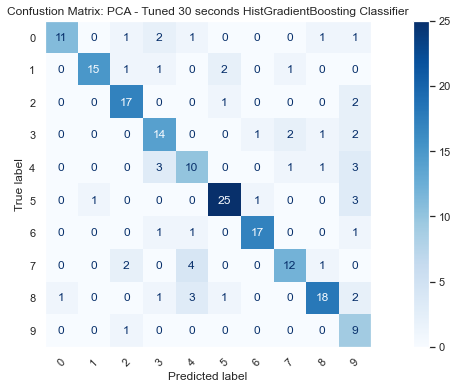

Accuracy : 0.74
Macro F-1 Score : 0.73


In [42]:
# Evaluate Model
class_labels = list(model_pca_tuned_hbg.classes_)
macro_f1, accuracy = evaluate_model(pcaTesthbg, y_test, class_labels,
                                    'Confustion Matrix: PCA - Tuned 30 seconds HistGradientBoosting Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

## GradientBoosting

### PCA - Original Model
Building a model with no parameter tuning and using the PCA data

In [43]:
model_pca_bg = GradientBoostingClassifier()
model_pca_bg.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainbg = model_pca_bg.predict(pca_data)
pcaTestbg = model_pca_bg.predict(pca_data_test)

In [44]:
pcatestbg_score =  accuracy_score(y_test, pcaTestbg)
pcabg_score = accuracy_score(y_dev, pcaTrainbg)

In [45]:
print("Classification Score for GradientBoosting Classifier on Train dataset:\n")
print("Train Score : ", pcabg_score)
print("--------------------------------------------------------")
print("Classification Score for GradientBoosting Classifier on Test dataset:\n")
print("Test Score :", pcatestbg_score)

Classification Score for GradientBoosting Classifier on Train dataset:

Train Score :  0.99875
--------------------------------------------------------
Classification Score for GradientBoosting Classifier on Test dataset:

Test Score : 0.675


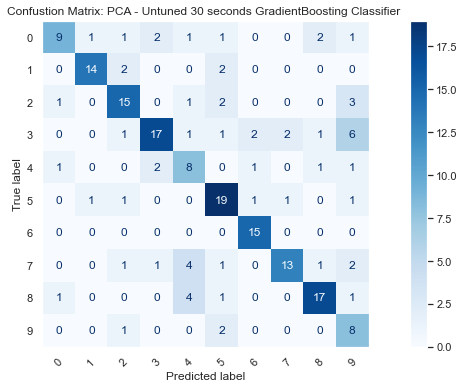

Accuracy : 0.68
Macro F-1 Score : 0.67


In [46]:
# Evaluate Model
class_labels = list(model_pca_bg.classes_)
macro_f1, accuracy = evaluate_model(pcaTestbg, y_test, class_labels,
                                    'Confustion Matrix: PCA - Untuned 30 seconds GradientBoosting Classifier ')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### PCA - Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the PCA data

In [47]:
pca_final.iloc[:,:30]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.777410,0.193198,-0.058681,-0.180358,-0.005488,-0.099418,-0.209192,-0.328523,0.078996,-0.157323,...,0.041165,0.038868,-0.014776,0.077619,0.042378,-0.022349,0.027487,0.072776,0.064374,-0.002495
1,-0.599829,0.260505,0.001988,-0.047122,0.131503,-0.098224,-0.077306,0.046255,-0.040616,0.094603,...,-0.041534,-0.046373,-0.068694,-0.016307,0.047816,0.034589,0.010604,0.052721,0.011093,-0.018114
2,-0.246233,-0.118150,0.065454,-0.036683,0.486624,-0.150015,-0.066610,-0.197734,0.041883,0.013262,...,0.088581,0.035792,0.010247,-0.059556,-0.157718,-0.009606,0.117418,0.033817,0.003053,-0.032089
3,-0.748761,0.347893,-0.050810,-0.060772,0.094122,0.043072,-0.091611,0.131255,-0.044354,0.123954,...,-0.015460,0.002813,-0.002246,-0.016255,0.033266,-0.038578,0.011985,0.000457,0.015948,-0.024016
4,0.390897,0.250941,-0.198188,0.293123,0.621651,0.005957,-0.025039,-0.233490,0.295023,0.131552,...,0.016740,-0.082243,0.057713,-0.016134,-0.016780,0.004757,-0.044126,-0.030980,-0.015806,0.015246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-0.565572,0.422083,0.328459,0.111136,-0.153392,-0.133144,0.121274,0.170829,0.181531,-0.003553,...,0.293489,-0.012800,0.058350,0.047841,0.083061,-0.066748,0.014930,-0.025305,-0.000576,0.010976
796,0.258810,-0.934083,0.031836,0.495334,0.077337,-0.114135,0.171023,-0.128289,0.103747,0.171771,...,0.028867,-0.007606,-0.040242,0.058971,0.156630,0.046094,-0.127337,-0.039484,0.098118,0.001165
797,1.243638,0.799851,0.648936,0.304699,-0.379732,0.291342,-0.171433,-0.020330,0.029568,-0.338996,...,-0.005325,-0.005846,0.016543,-0.003658,0.054954,-0.001606,-0.058225,-0.101575,-0.042101,0.014038
798,0.251711,0.398993,-0.418890,-0.045822,0.030828,0.140385,-0.063128,-0.085624,-0.096346,0.127764,...,0.080396,-0.048845,0.017187,-0.002996,-0.023183,0.127376,-0.093147,-0.051952,0.023988,-0.100967


In [48]:
model_pca_tuned_bg = best_gb
model_pca_tuned_bg.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainbg_tuned = model_pca_tuned_bg.predict(pca_data)
pcaTestbg_tuned = model_pca_tuned_bg.predict(pca_data_test)

In [49]:
pcatestbg_score =  accuracy_score(y_test, pcaTestbg)
pcabg_score = accuracy_score(y_dev, pcaTrainbg)

In [50]:
print("Classification Score for GradientBoosting Classifier on Train dataset:\n")
print("Train Score : ", pcabg_score)
print("--------------------------------------------------------")
print("Classification Score for GradientBoosting Classifier on Test dataset:\n")
print("Test Score :", pcatestbg_score)

Classification Score for GradientBoosting Classifier on Train dataset:

Train Score :  0.99875
--------------------------------------------------------
Classification Score for GradientBoosting Classifier on Test dataset:

Test Score : 0.675


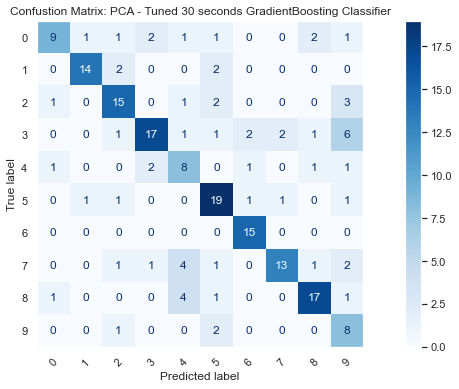

Accuracy : 0.68
Macro F-1 Score : 0.67


In [51]:
# Evaluate Model
class_labels = list(model_pca_tuned_bg.classes_)
macro_f1, accuracy = evaluate_model(pcaTestbg, y_test, class_labels,
                                    'Confustion Matrix: PCA - Tuned 30 seconds GradientBoosting Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

## XGB

### PCA - Original Model
Building a model with no parameter tuning and using the PCA data

In [52]:
model_pca_xbg = XGBClassifier()
model_pca_xbg.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainxbg = model_pca_xbg.predict(pca_data)
pcaTestxbg = model_pca_xbg.predict(pca_data_test)

In [53]:
pcatestxbg_score =  accuracy_score(y_test, pcaTestxbg)
pcaxbg_score = accuracy_score(y_dev, pcaTrainxbg)

In [54]:
print("Classification Score for XGB Classifier on Train dataset:\n")
print("Train Score : ", pcaxbg_score)
print("--------------------------------------------------------")
print("Classification Score for XGB Classifier on Test dataset:\n")
print("Test Score :", pcatestxbg_score)

Classification Score for XGB Classifier on Train dataset:

Train Score :  0.99875
--------------------------------------------------------
Classification Score for XGB Classifier on Test dataset:

Test Score : 0.685


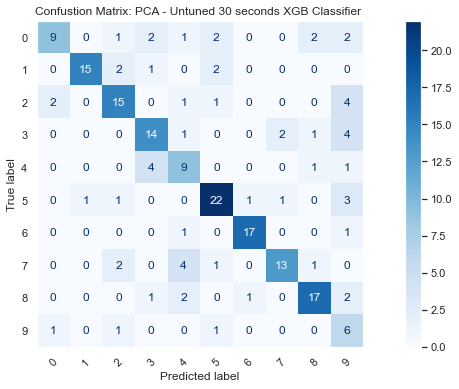

Accuracy : 0.69
Macro F-1 Score : 0.67


In [55]:
# Evaluate Model
class_labels = list(model_pca_xbg.classes_)
macro_f1, accuracy = evaluate_model(pcaTestxbg, y_test, class_labels,
                                    'Confustion Matrix: PCA - Untuned 30 seconds XGB Classifier ')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### PCA - Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the PCA data

In [56]:
pca_final.iloc[:,:30]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.777410,0.193198,-0.058681,-0.180358,-0.005488,-0.099418,-0.209192,-0.328523,0.078996,-0.157323,...,0.041165,0.038868,-0.014776,0.077619,0.042378,-0.022349,0.027487,0.072776,0.064374,-0.002495
1,-0.599829,0.260505,0.001988,-0.047122,0.131503,-0.098224,-0.077306,0.046255,-0.040616,0.094603,...,-0.041534,-0.046373,-0.068694,-0.016307,0.047816,0.034589,0.010604,0.052721,0.011093,-0.018114
2,-0.246233,-0.118150,0.065454,-0.036683,0.486624,-0.150015,-0.066610,-0.197734,0.041883,0.013262,...,0.088581,0.035792,0.010247,-0.059556,-0.157718,-0.009606,0.117418,0.033817,0.003053,-0.032089
3,-0.748761,0.347893,-0.050810,-0.060772,0.094122,0.043072,-0.091611,0.131255,-0.044354,0.123954,...,-0.015460,0.002813,-0.002246,-0.016255,0.033266,-0.038578,0.011985,0.000457,0.015948,-0.024016
4,0.390897,0.250941,-0.198188,0.293123,0.621651,0.005957,-0.025039,-0.233490,0.295023,0.131552,...,0.016740,-0.082243,0.057713,-0.016134,-0.016780,0.004757,-0.044126,-0.030980,-0.015806,0.015246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-0.565572,0.422083,0.328459,0.111136,-0.153392,-0.133144,0.121274,0.170829,0.181531,-0.003553,...,0.293489,-0.012800,0.058350,0.047841,0.083061,-0.066748,0.014930,-0.025305,-0.000576,0.010976
796,0.258810,-0.934083,0.031836,0.495334,0.077337,-0.114135,0.171023,-0.128289,0.103747,0.171771,...,0.028867,-0.007606,-0.040242,0.058971,0.156630,0.046094,-0.127337,-0.039484,0.098118,0.001165
797,1.243638,0.799851,0.648936,0.304699,-0.379732,0.291342,-0.171433,-0.020330,0.029568,-0.338996,...,-0.005325,-0.005846,0.016543,-0.003658,0.054954,-0.001606,-0.058225,-0.101575,-0.042101,0.014038
798,0.251711,0.398993,-0.418890,-0.045822,0.030828,0.140385,-0.063128,-0.085624,-0.096346,0.127764,...,0.080396,-0.048845,0.017187,-0.002996,-0.023183,0.127376,-0.093147,-0.051952,0.023988,-0.100967


In [57]:
model_pca_tuned_xbg = best_xgb
model_pca_tuned_xbg.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainxbg_tuned = model_pca_tuned_xbg.predict(pca_data)
pcaTestxbg_tuned = model_pca_tuned_xbg.predict(pca_data_test)

In [58]:
pcatestxbg_score =  accuracy_score(y_test, pcaTestxbg)
pcaxbg_score = accuracy_score(y_dev, pcaTrainxbg)

In [59]:
print("Classification Score for XGB Classifier on Train dataset:\n")
print("Train Score : ", pcaxbg_score)
print("--------------------------------------------------------")
print("Classification Score for XGB Classifier on Test dataset:\n")
print("Test Score :", pcatestxbg_score)

Classification Score for XGB Classifier on Train dataset:

Train Score :  0.99875
--------------------------------------------------------
Classification Score for XGB Classifier on Test dataset:

Test Score : 0.685


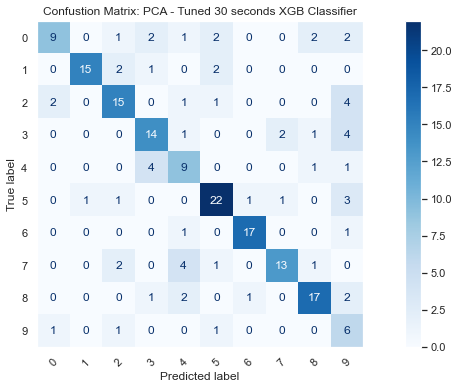

Accuracy : 0.69
Macro F-1 Score : 0.67


In [60]:
# Evaluate Model
class_labels = list(model_pca_tuned_xbg.classes_)
macro_f1, accuracy = evaluate_model(pcaTestxbg, y_test, class_labels,
                                    'Confustion Matrix: PCA - Tuned 30 seconds XGB Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

## SVM

In [61]:
model_pca_svm = SVC()
model_pca_svm.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainsvm = model_pca_svm.predict(pca_data)
pcaTestsvm = model_pca_svm.predict(pca_data_test)

In [62]:
pcatestsvm_score =  accuracy_score(y_test, pcaTestsvm)
pcasvm_score = accuracy_score(y_dev, pcaTrainsvm)

In [63]:
print("Classification Score for SVM Classifier on Train dataset:\n")
print("Train Score : ", pcasvm_score)
print("--------------------------------------------------------")
print("Classification Score for SVM Classifier on Test dataset:\n")
print("Test Score :", pcatestsvm_score)

Classification Score for SVM Classifier on Train dataset:

Train Score :  0.85625
--------------------------------------------------------
Classification Score for SVM Classifier on Test dataset:

Test Score : 0.775


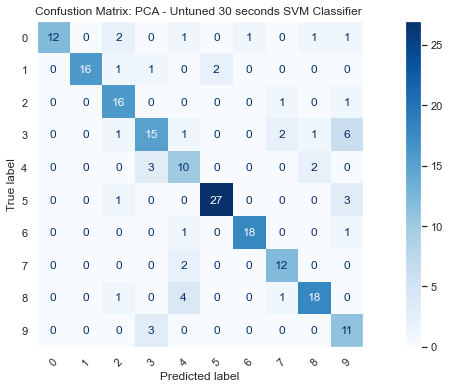

Accuracy : 0.78
Macro F-1 Score : 0.77


In [64]:
# Evaluate Model
class_labels = list(model_pca_svm.classes_)
macro_f1, accuracy = evaluate_model(pcaTestsvm, y_test, class_labels,
                                    'Confustion Matrix: PCA - Untuned 30 seconds SVM Classifier ')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### PCA - Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the PCA data

In [65]:
pca_final.iloc[:,:30]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.777410,0.193198,-0.058681,-0.180358,-0.005488,-0.099418,-0.209192,-0.328523,0.078996,-0.157323,...,0.041165,0.038868,-0.014776,0.077619,0.042378,-0.022349,0.027487,0.072776,0.064374,-0.002495
1,-0.599829,0.260505,0.001988,-0.047122,0.131503,-0.098224,-0.077306,0.046255,-0.040616,0.094603,...,-0.041534,-0.046373,-0.068694,-0.016307,0.047816,0.034589,0.010604,0.052721,0.011093,-0.018114
2,-0.246233,-0.118150,0.065454,-0.036683,0.486624,-0.150015,-0.066610,-0.197734,0.041883,0.013262,...,0.088581,0.035792,0.010247,-0.059556,-0.157718,-0.009606,0.117418,0.033817,0.003053,-0.032089
3,-0.748761,0.347893,-0.050810,-0.060772,0.094122,0.043072,-0.091611,0.131255,-0.044354,0.123954,...,-0.015460,0.002813,-0.002246,-0.016255,0.033266,-0.038578,0.011985,0.000457,0.015948,-0.024016
4,0.390897,0.250941,-0.198188,0.293123,0.621651,0.005957,-0.025039,-0.233490,0.295023,0.131552,...,0.016740,-0.082243,0.057713,-0.016134,-0.016780,0.004757,-0.044126,-0.030980,-0.015806,0.015246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-0.565572,0.422083,0.328459,0.111136,-0.153392,-0.133144,0.121274,0.170829,0.181531,-0.003553,...,0.293489,-0.012800,0.058350,0.047841,0.083061,-0.066748,0.014930,-0.025305,-0.000576,0.010976
796,0.258810,-0.934083,0.031836,0.495334,0.077337,-0.114135,0.171023,-0.128289,0.103747,0.171771,...,0.028867,-0.007606,-0.040242,0.058971,0.156630,0.046094,-0.127337,-0.039484,0.098118,0.001165
797,1.243638,0.799851,0.648936,0.304699,-0.379732,0.291342,-0.171433,-0.020330,0.029568,-0.338996,...,-0.005325,-0.005846,0.016543,-0.003658,0.054954,-0.001606,-0.058225,-0.101575,-0.042101,0.014038
798,0.251711,0.398993,-0.418890,-0.045822,0.030828,0.140385,-0.063128,-0.085624,-0.096346,0.127764,...,0.080396,-0.048845,0.017187,-0.002996,-0.023183,0.127376,-0.093147,-0.051952,0.023988,-0.100967


In [66]:
model_pca_tuned_svm = best_svm
model_pca_tuned_svm.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainsvm_tuned = model_pca_tuned_svm.predict(pca_data)
pcaTestsvm_tuned = model_pca_tuned_svm.predict(pca_data_test)

In [67]:
pcatestsvm_score =  accuracy_score(y_test, pcaTestsvm)
pcasvm_score = accuracy_score(y_dev, pcaTrainsvm)

In [68]:
print("Classification Score for SVM Classifier on Train dataset:\n")
print("Train Score : ", pcasvm_score)
print("--------------------------------------------------------")
print("Classification Score for SVM Classifier on Test dataset:\n")
print("Test Score :", pcatestsvm_score)

Classification Score for SVM Classifier on Train dataset:

Train Score :  0.85625
--------------------------------------------------------
Classification Score for SVM Classifier on Test dataset:

Test Score : 0.775


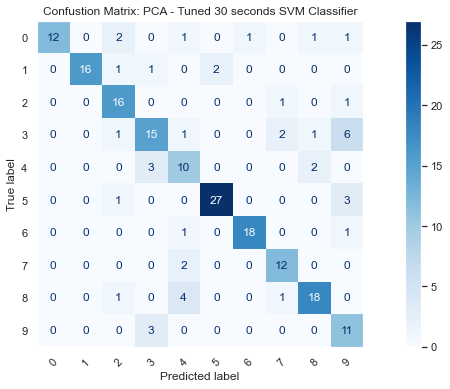

Accuracy : 0.78
Macro F-1 Score : 0.77


In [69]:
# Evaluate Model
class_labels = list(model_pca_tuned_svm.classes_)
macro_f1, accuracy = evaluate_model(pcaTestsvm, y_test, class_labels,
                                    'Confustion Matrix: PCA - Tuned 30 seconds SVM Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)